# NBD Assignment

Alessandro Gallo, Lorenzo lancia, Federico Pula, Gerta Salillari

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from numpy import linalg as LA
from networkx.drawing.nx_agraph import graphviz_layout
%matplotlib inline
import seaborn as sbn
from collections import Counter

# 1) Random graphs with different models

Random graph is the general term to refer to probability distributions over graphs. Random graphs may be described simply by a probability distribution, or by a random process which generates them. We consider two kind of random graphs, Erdos-Renyi's and r-regulars.

## 1.1 Erdos-Renyi random graph

The Erdos-Renyi random graph can be made in two ways, the $G_N(M)$ model and $G_N(p)$ model.

###  1.1.1   $G_N(M)$ model:

The graph is chosen uniformly at random from the collection of all graph which have N nodes and M edges.

Algorithm:


In [2]:
def create_erdos_gnm (N, M):
    G = nx.Graph()
    nodes = range(N)
    G.add_nodes_from(nodes)
    edges = [(n,nodes[i]) for n in range(N) for i in nodes[:n] if i != n ]
    random.shuffle(edges)
    G.add_edges_from(edges[:M])
    return G

For example, with $N=10$ and $M=10$:

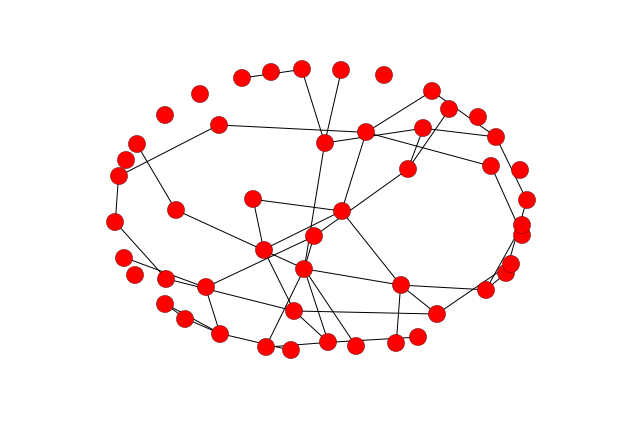

In [32]:
G1 = create_erdos_gnm(50,50)
nx.draw(G1)

### 1.1.2 $G_N(p)$ model: 

The graph is constructed by connecting nodes randomly. Each edge is included in the graph with probability $p$ independent from every other edge

In [4]:
def create_erdos_gnp (N, P):
    G = nx.Graph()
    # Add N nodes
    nodes = range(N)
    G.add_nodes_from(nodes)
    # all possible edges
    edges = [(n,nodes[i]) for n in range(N) for i in nodes[:n] if i != n ]
    for edge in edges:
        if random.random() < P :
            G.add_edge(edge[0],edge[1])
    return G

Let's see an example with $N=50$ nodes and a $P=0.2$ probability:

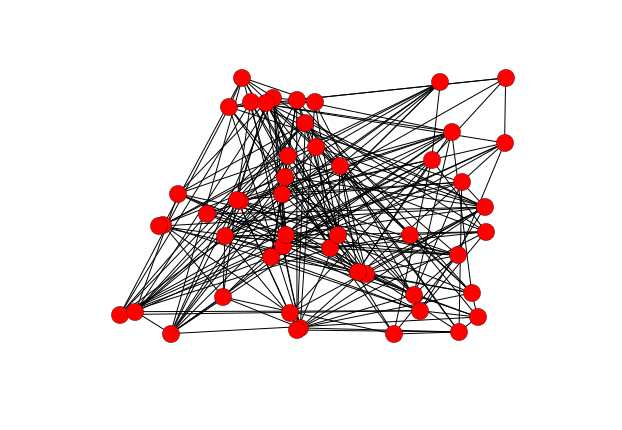

In [5]:
G2 = create_erdos_gnp(50,0.2)
nx.draw_random(G2)

## 1.2 R-regular random graph:

In the R-regular random graph the graph is selected from $G_{N,R}$ , which denotes the probability space of all R -regular graphs on n vertices, where 3 $\leq$ R $\le$ N and $NR$ is even.

1. An $R$ regular graph is a graph where each vertex has the same number $R$ of neighbors
2. $R$ regular graphs for $R = 0,1,2$ are trivial.

Algorithm:

In [6]:
def create_randomregular(N,R):
    
# 1) Check if NR is even
    if (N*R)%2 != 0:
        print "NR is not even"
        return None
    
    # 2) Iterate untile the graph is not a regular random graph
    while 1:
        G = nx.Graph()
        nodes = range(N)
        G.add_nodes_from(nodes)
        
        # 3) Generate all possible edges
        list_of_all_edges = [(n,nodes[i]) for n in range(N) for i in nodes[:n] if i != n]
        
        # 4) Itereate untile list of possible edges is empty
        while list_of_all_edges: 
        
        # 5) Extract a random edge and add it to the graph
            extracted = random.randint(0,len(list_of_all_edges)-1)
            edge = list_of_all_edges[extracted]
            G.add_edge(edge[0],edge[1])
            
            # 6) Filter the list of possible edges by removing edges connecting nodes that have maximum degree
            list_of_all_edges = [item for item in list_of_all_edges if G.degree()[item[0]]<R and  G.degree()[item[1]]<R]
            
            # 7) Filter the list of possible edges by removing edges connecting neighbours
            list_of_all_edges = [item for item in list_of_all_edges if item[0] not in G.neighbors(item[1])]                
            
            # 8) Check if resultig graph is a regular random graph, if not restart from beginning
        n_nodes_rank_less_than_R = len([i for i in G.degree().values() if i <R])
        if  n_nodes_rank_less_than_R ==0:
            break

    return G

    

For example with $N=50$ and $R=4$:

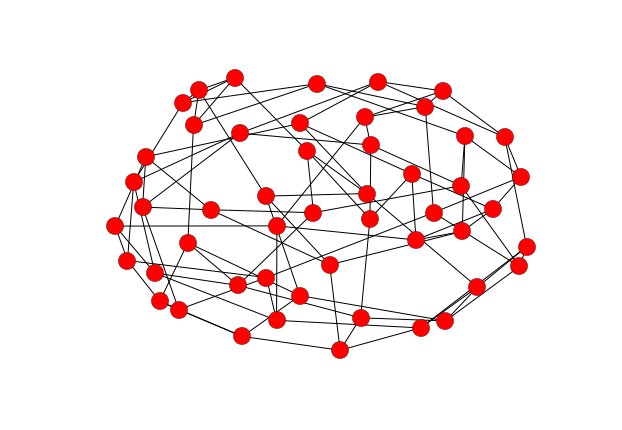

In [7]:
G3= create_randomregular(50,4)
nx.draw(G3)


# Fat Tree

In [8]:
def fat_tree_generator(N):
    G = nx.Graph()
    cores = range(N)
    
    aggregations = range(N,N+2*N)
    
    links = []
    
    i=0
    j=0
    for router in aggregations:
        while (1):
            links.append((router, (i+j)%len(cores)))
            i+=1
            if i%N==0:
                j+=1
            if i%(N/2)==0:
                break
    
    edges= range(N+2*N, (N+2*N+2*N))
    
    links2 = []
    i= 0
    for j in range(len(aggregations)):
        for k in range(i*N/2, i*N/2+N/2):
            links2.append( (aggregations[j], edges[k]))
        if (j+1)%(N/2) ==0:
            i+=1
    
    
    hosts = range((N+2*N+2*N), (N+2*N+2*N)+len(links2)) 
    links3 = [(hosts[i], edges[i/(N/2)]) for i in range(len(hosts))]
    
    
    G.add_edges_from(links)
    G.add_edges_from(links2)
    G.add_edges_from(links3)
    return G

In [9]:
G_fat = fat_tree_generator(16)

(-400.0, 400.0, -400.0, 400.0)

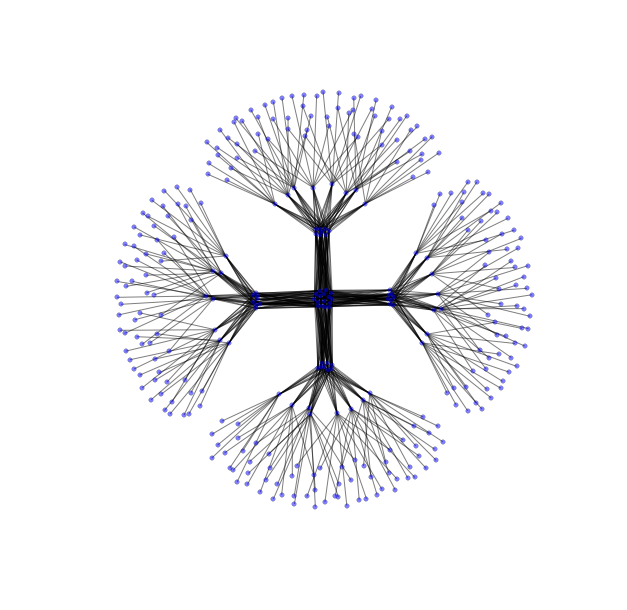

In [10]:
pos=graphviz_layout(G_fat, prog="neato", args="")
plt.figure(figsize=(8,8))
nx.draw(G_fat,pos,node_size=20,alpha=0.5,node_color="blue")
plt.axis('equal')


# 3) Connectivity of a graph

A graph is connected when there is a path between every pair of vertices. In a connected graph, there are no unreachable vertices. A graph that is not connected is disconnected. 
There are three ways to check if the graph is connected:

1. Algebraic method 1 (irreducibility)
2. Algebraic method 2 (eigenvalue of the Laplacian matrix)
3. Breadth-first based algorithm


## 3.1 Algebraic method 1 (irreducibility)

We check the connectivity looking at the adjacency matrix A, that has to be irreducible. 

An nxn matrix A is irreducible if:

$I + A + A^{2} +... + A^{n-􀀀}1 > 0$

In [12]:
def irreducibility(G):
    N = len(G.nodes())
    #Matrice d'identità
    Id=np.identity(N)
    #Matrice d'adiacenza
    A=[[0 for n in range(N)] for k in range(N)]
    for i in G1.edges():
        A[i[0]][i[1]]=1
        A[i[1]][i[0]]=1
    #Irreducibilità
    
    M=Id+A   
    
    for k in range(2,N):
        M=M+np.linalg.matrix_power(A,k)
    #Condizione
    if (M.all()>0):
        #print "Graph is connected"
        return True
    else:
        #print "Graph is not connected"
        return False
        
irreducibility(G1)

False

## 3.2 Algebraic method 2 (eigenvalue of the Laplacian matrix)

We check the connectivity of the graph looking if the second smallest eigenvalue of the Laplacian matrix is positive.

The Laplacian L of a graph in an nxn matrix is defined with:

$L_{ii} = d_{i}  \text{ , where } d_{i} \text{ is the degree of node } i$

$L_{ij} = 1 \iff  (i,j) \in A$

Algorithm:

In [13]:
def laplacian(G):
    N = len(G.nodes())
    # 1) Laplacian Matrix
    L=[[0 for n in range(N)] for k in range(N)]
    for k in range(N):
        L[k][k]=G.degree([k]).values()[0]
    for j in G.edges():
        L[j[0]][j[1]]=-1
        L[j[1]][j[0]]=-1
        
    # 2) Second smallest eigenvalue
    eig = LA.eig(L)[0]
    small=np.sort(eig)[1]
    
    # 3) Condition
    cond=small
    if cond>0:
        #print "Graph is connected"
        return True
    else:
        #print "Graph is not connected"
        return False


lapl=laplacian(G1)

Graph is not connected


## 3.3 Breadth-first based algorithm

Breadth-first search (BFS) is an algorithm for traversing or searching tree or graph data structures. It starts at the tree root (or some arbitrary node of a graph) and explores the neighbor nodes first, before moving to the next level neighbors.

Algorithm: 

In [14]:
def BF_search(G, R):
    # R is the root for searching
    data = [{"id":i, "dist": -1, "parent": None} for i in G.nodes()]
    queue = [R]
    data[R]["dist"]=0
    while queue:
        
        i_node = queue.pop(0)
        
        for neighbour in G.neighbors(i_node):
            if data[neighbour]["dist"] == -1:
                
                data[neighbour]["dist"]=data[i_node]["dist"]+1
                data[neighbour]["parent"] = i_node
                queue.append(neighbour)
    return data

In [15]:
def check_connectivity_bf(G):
    nodes = G.nodes()
    R = nodes[random.randint(0,len(nodes)-1)]
    result = BF_search(G,R)
    for node in result:
        if node["dist"]==-1:
            #print "Graph is not connected"
            return False
    return True

check_connectivity_bf(G2)

True

## Number of flows and max Throughput

#### Max throughput

Assumens:

* Each links have the same capacity $C$.


* Only one shortest path is used from a couple of nodes i and j.


* $R$ is bit rate of the traffic flows form a node to every other node.


* $L(i,j)$, called load, is a sum of a bit rate of all flows using link $(i,j)$.


* $f(i,j)$ is a number of flows routed link $(i,j)$.

From assumption below it is possible compute the load between i and j

$$
L(i,j) = f(i,j) \times R
$$

Since the load hat to be always less or equal than the capacity of the node $L(i,j) \leq C$, 
the max throughput can be computed by 

$$
R_{max} = \frac{C}{max(f(u,v))}, \,\,\, \forall \,\, u,v \in \mbox(shortest path (i,j))
$$

In [16]:
def number_of_flows(G):
    if not check_connectivity_bf(G):
        print "Error: Graph not connected"
        return None
    
    shortest_path = nx.all_pairs_shortest_path(G)
    nodes = G.nodes()
    edges = [(n,nodes[i]) for n in range(len(nodes)) for i in nodes[:n] if i != n ]
    all_shortest_path = [shortest_path[i[0]][i[1]] for i in edges]
    all_traffic = [[(item[i], item[i+1]) for i in range(len(item)-1)] for item in all_shortest_path]
    trafficlist = []
    for item in all_traffic:
        trafficlist.extend(item)
    
    counter = Counter(trafficlist)
    
    return counter

## Max Troughput  of a $G_n(p)$ graph

In [17]:
troughput_graph = [max(number_of_flows(create_erdos_gnp(100,0.5)).values()) for n in range(1000)]

In [18]:
troughput_graph.sort()
troughput_graph = np.power(np.array(troughput_graph, dtype="float32"),-1)
print troughput_graph[25], troughput_graph[975]


0.0357143 0.0263158


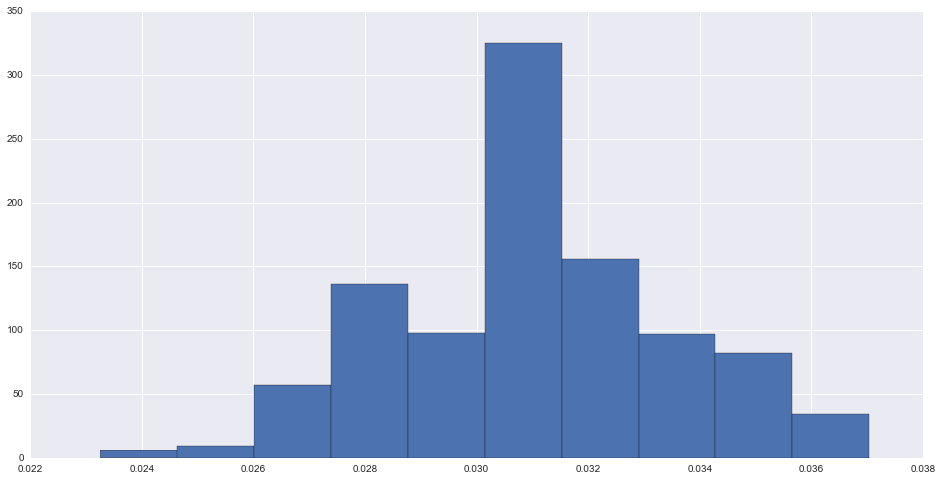

In [19]:
plt.figure(figsize=(16,8))
figure = plt.hist(troughput_graph)


## Probability of obtaining a connected Erdos $G_n(p)$ graph as function of $p$

In [20]:
datas = [(i, np.mean([check_connectivity_bf(create_erdos_gnp(100, i)) for l in range(1000)])) for i in np.linspace(0,0.15,10)]


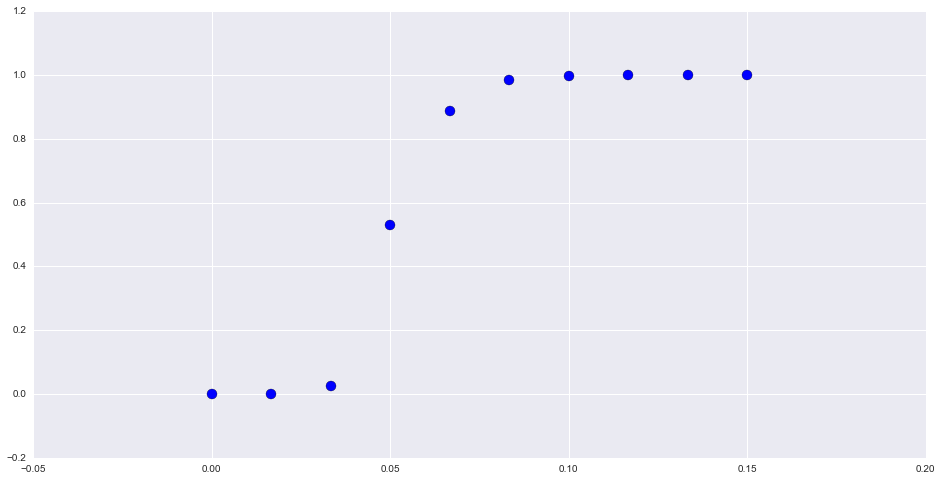

In [21]:
plt.figure(figsize=(16,8))
figure = plt.scatter(*zip(*datas), s=100)

## Load distribution of a $G_N(p)$ graph

in figure $N=50$ and  $P=0.2$

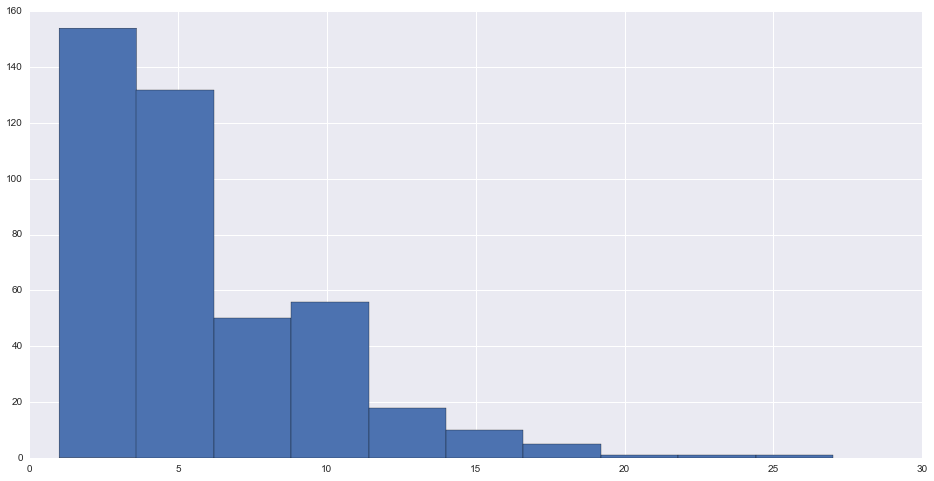

In [23]:
load_list = number_of_flows(G2).values()
load_list.sort()
plt.figure(figsize=(16,8))
figure = plt.hist(load_list, bins=10)

## Probability of obtaining a connected Regular random graph as function of $n$
with $r = 8$

In [24]:
datas2 = [(i, np.mean([check_connectivity_bf(nx.random_regular_graph(8, i)) for l in range(1000)])) for i in np.arange(10,100,10)]

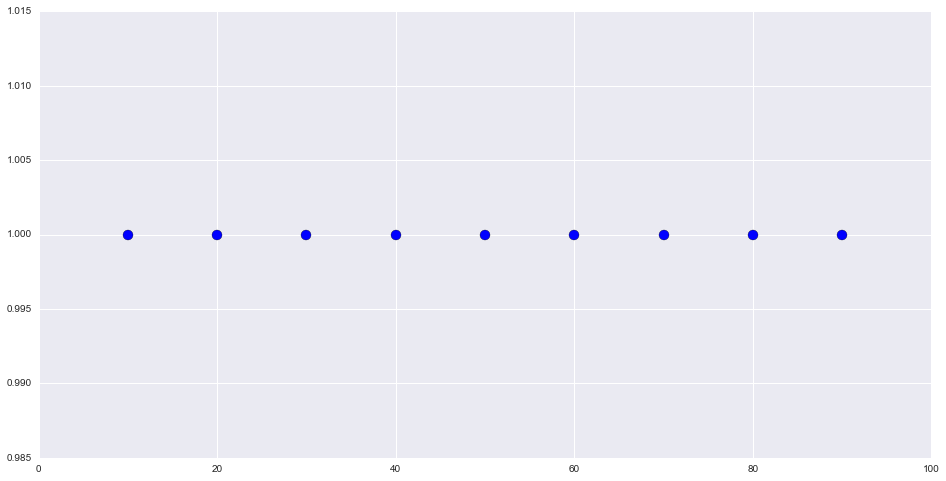

In [25]:
plt.figure(figsize=(16,8))
figure = plt.scatter(*zip(*datas2), s=100)

## Probability of obtaining a connected Regular random graph as function of $n$
with $r = 2$

In [26]:
datas3 = [(i, np.mean([check_connectivity_bf(nx.random_regular_graph(2, i)) for l in range(1000)])) for i in np.arange(10,100,10)]

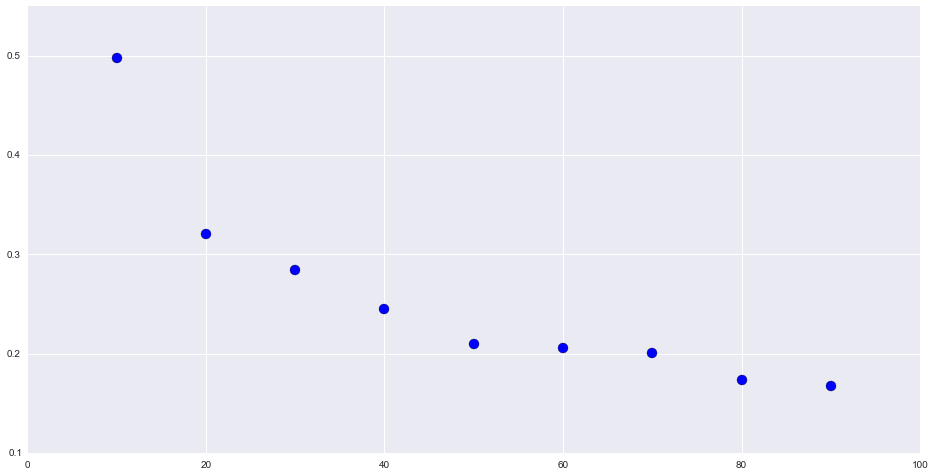

In [27]:
plt.figure(figsize=(16,8))
figure = plt.scatter(*zip(*datas3), s=100)

## Max Throughput of a Random regular graph 

In [28]:
troughput_graph2 = [max(number_of_flows(nx.random_regular_graph(8,100)).values()) for n in range(1000)]

In [29]:
troughput_graph2.sort()
troughput_graph2 = np.power(np.array(troughput_graph2, dtype="float32"),-1)
print troughput_graph2[25], troughput_graph2[975]


0.0232558 0.0172414


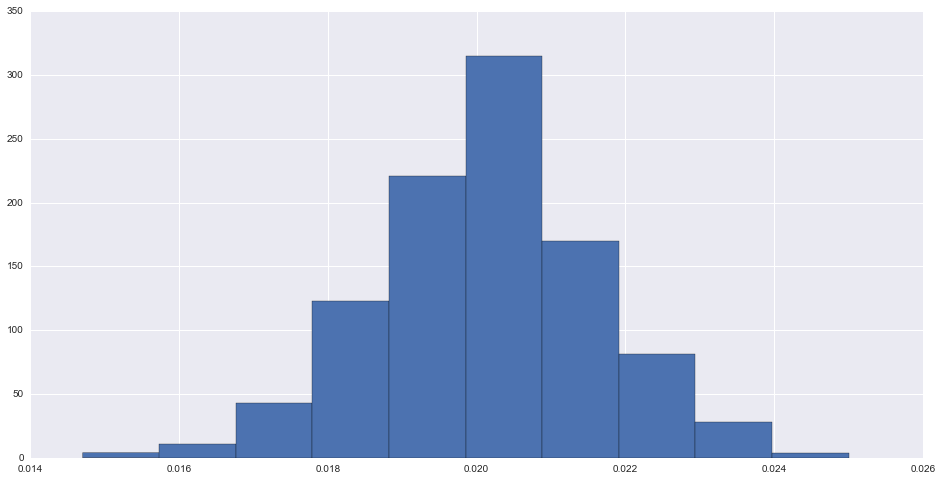

In [30]:
plt.figure(figsize=(16,8))
figure = plt.hist(troughput_graph2)


## Load distribution of a random regular graph

in figure $N=100$ and  $R=8$

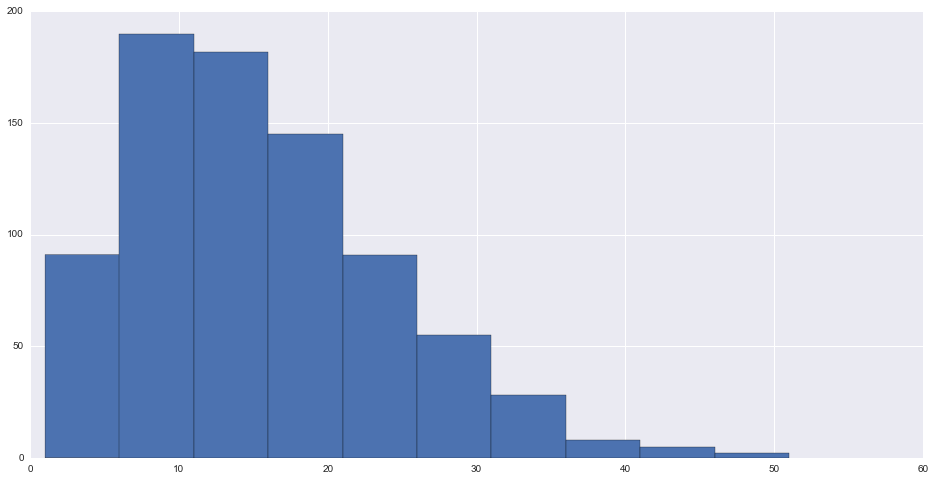

In [31]:
load_list = number_of_flows(nx.random_regular_graph(8,100)).values()
load_list.sort()
plt.figure(figsize=(16,8))

figure = plt.hist(load_list)
